##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array

## Download and explore the dataset

The dataset contains two classes:

```
children_Toys_photo/
  Safe/
  Unsafe
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data using a Keras utility



### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

80% of the images for training and 20% for validation.

In [ ]:
train_path = tf.keras.utils.image_dataset_from_directory (
  '/content/drive/MyDrive/Dataset/400TrainingCNN',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 320 files for training.


In [ ]:
val_path = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Dataset/400TrainingCNN',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 80 files for validation.


In [ ]:
class_names = train_path.class_names
print(class_names)

['Safe', 'Unsafe']


## Visualize the data



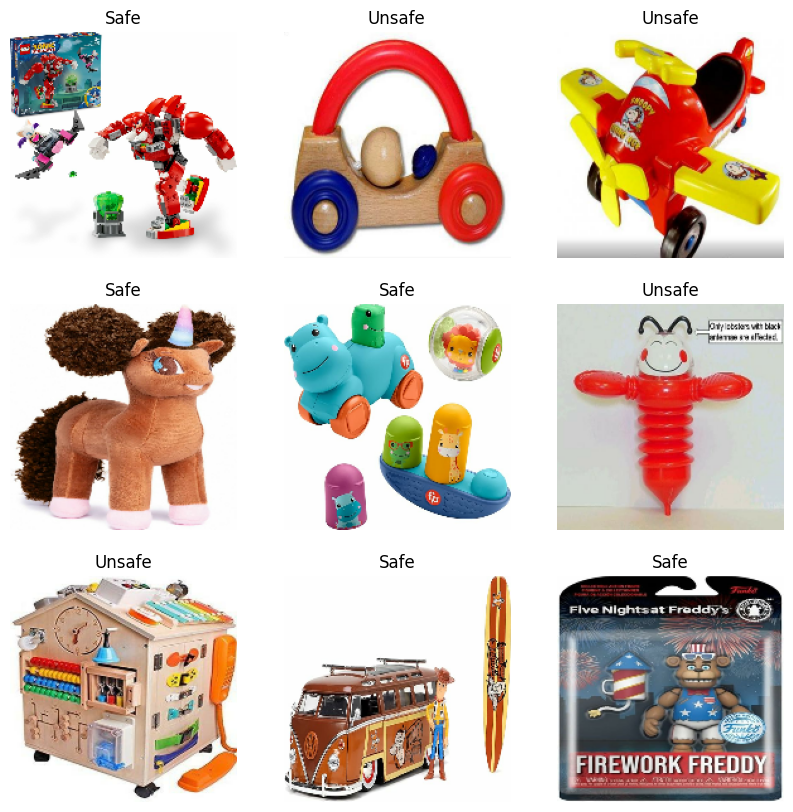

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_path.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_path:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 200, 200, 3)`. This is a batch of 32 images of shape `200x200x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_path = train_path.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_path = val_path.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general make your input values small.

Standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_path = train_path.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_path))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model



In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs=10
history = model.fit(
  train_path,
  validation_data=val_path,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 0.9007 - accuracy: 0.5250 - val_loss: 0.6976 - val_accuracy: 0.4750
Epoch 2/10
10/10 [==============================] - 0s 28ms/step - loss: 0.6521 - accuracy: 0.5656 - val_loss: 0.6404 - val_accuracy: 0.7875
Epoch 3/10
10/10 [==============================] - 0s 29ms/step - loss: 0.5965 - accuracy: 0.6875 - val_loss: 0.5317 - val_accuracy: 0.7625
Epoch 4/10
10/10 [==============================] - 0s 29ms/step - loss: 0.5254 - accuracy: 0.7031 - val_loss: 0.4469 - val_accuracy: 0.8625
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.4647 - accuracy: 0.7812 - val_loss: 0.5534 - val_accuracy: 0.7000
Epoch 6/10
10/10 [==============================] - 0s 27ms/step - loss: 0.3705 - accuracy: 0.8469 - val_loss: 0.5731 - val_accuracy: 0.7000
Epoch 7/10
10/10 [==============================] - 0s 22ms/step - loss: 0.3175 - accuracy: 0.8750 - val_loss: 0.3535 - val_accuracy: 0.8625
Epoch 8/10
10/

## Visualize training results

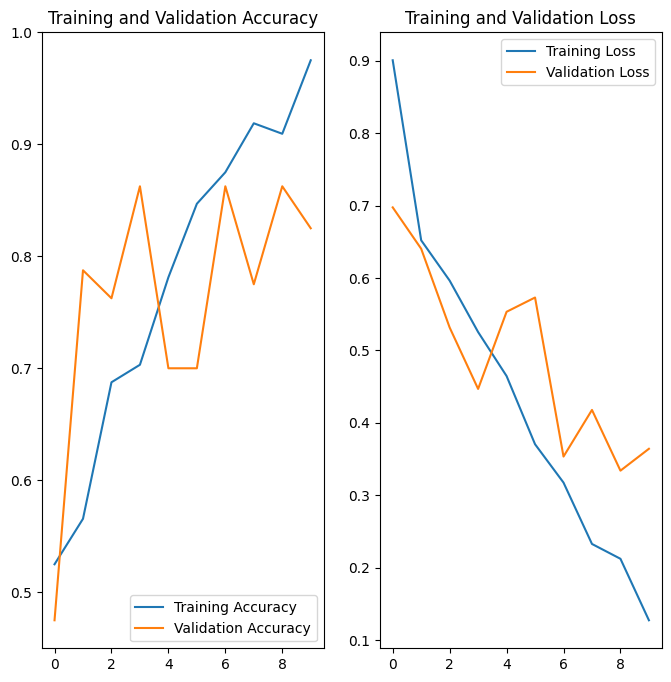

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 75% accuracy on the validation set.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

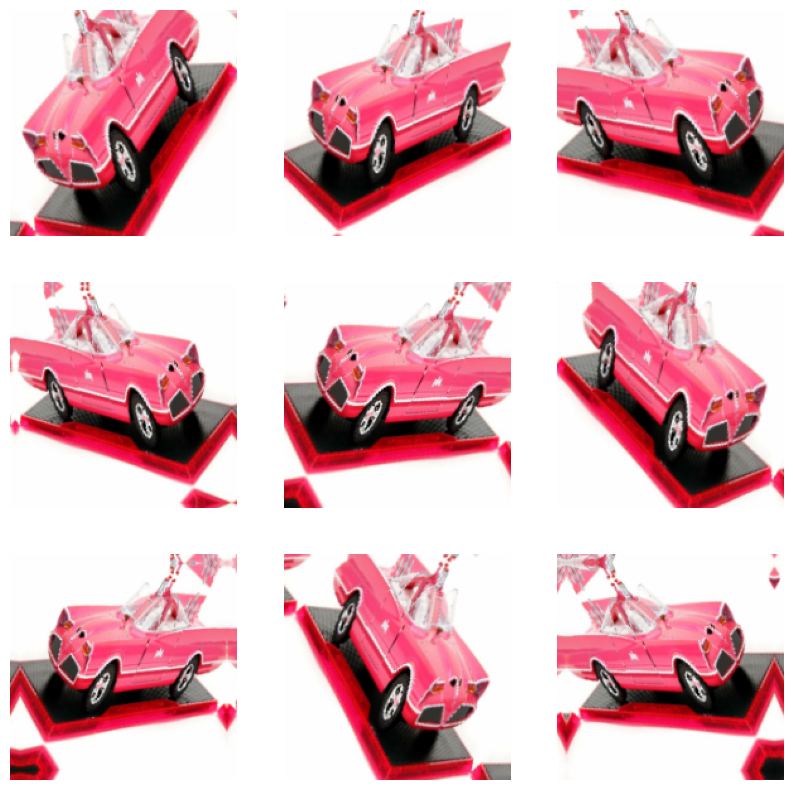

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_path.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

It randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 10
history = model.fit(
  train_path,
  validation_data=val_path,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 3s 54ms/step - loss: 0.8364 - accuracy: 0.4938 - val_loss: 0.6827 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 0s 35ms/step - loss: 0.6926 - accuracy: 0.5063 - val_loss: 0.6773 - val_accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 30ms/step - loss: 0.6748 - accuracy: 0.5406 - val_loss: 0.6359 - val_accuracy: 0.6375
Epoch 4/10
10/10 [==============================] - 0s 30ms/step - loss: 0.6416 - accuracy: 0.6187 - val_loss: 0.5218 - val_accuracy: 0.7375
Epoch 5/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5794 - accuracy: 0.7063 - val_loss: 0.5091 - val_accuracy: 0.7375
Epoch 6/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5775 - accuracy: 0.7063 - val_loss: 0.6778 - val_accuracy: 0.6750
Epoch 7/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5506 - accuracy: 0.7094 - val_loss: 0.5237 - val_accuracy: 0.7250
Epoch 8/10
10

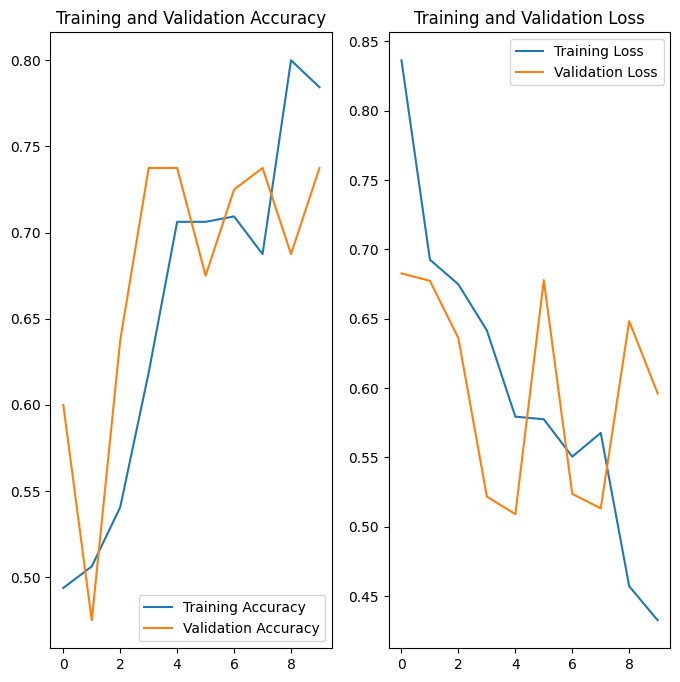

In [ ]:
# Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 15
history = model.fit(
  train_path,
  validation_data=val_path,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 0s 29ms/step - loss: 0.3882 - accuracy: 0.8219 - val_loss: 0.6450 - val_accuracy: 0.7125
Epoch 2/15
10/10 [==============================] - 0s 29ms/step - loss: 0.3787 - accuracy: 0.8188 - val_loss: 0.8206 - val_accuracy: 0.6750
Epoch 3/15
10/10 [==============================] - 0s 34ms/step - loss: 0.4207 - accuracy: 0.8094 - val_loss: 0.5159 - val_accuracy: 0.7875
Epoch 4/15
10/10 [==============================] - 0s 29ms/step - loss: 0.3910 - accuracy: 0.8094 - val_loss: 0.4193 - val_accuracy: 0.8500
Epoch 5/15
10/10 [==============================] - 0s 29ms/step - loss: 0.4738 - accuracy: 0.7625 - val_loss: 0.3834 - val_accuracy: 0.8750
Epoch 6/15
10/10 [==============================] - 0s 34ms/step - loss: 0.3820 - accuracy: 0.8406 - val_loss: 0.5777 - val_accuracy: 0.7375
Epoch 7/15
10/10 [==============================] - 0s 31ms/step - loss: 0.3428 - accuracy: 0.8656 - val_loss: 1.0789 - val_accuracy: 0.6500
Epoch 8/15
10

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

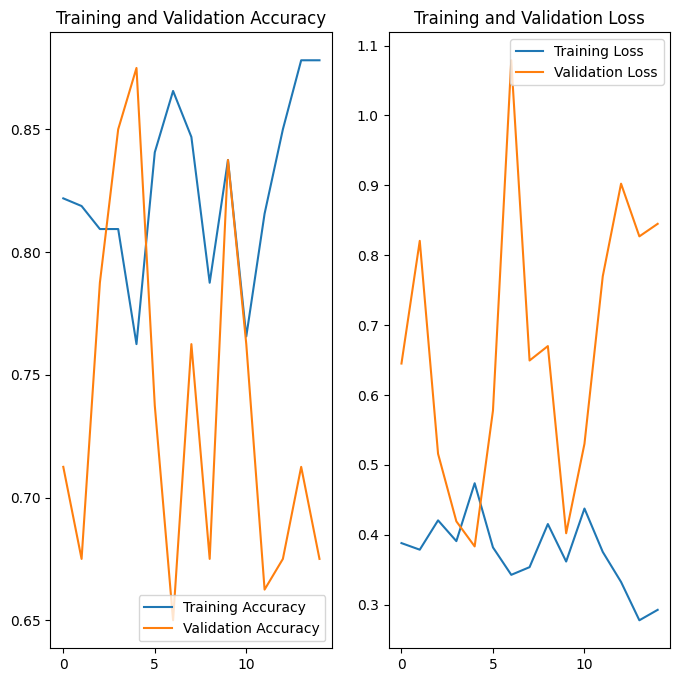

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 20
history = model.fit(
  train_path,
  validation_data=val_path,
  epochs=epochs
)

Epoch 1/20
10/10 [==============================] - 2s 55ms/step - loss: 0.2813 - accuracy: 0.8719 - val_loss: 0.9272 - val_accuracy: 0.6750
Epoch 2/20
10/10 [==============================] - 0s 31ms/step - loss: 0.2614 - accuracy: 0.8719 - val_loss: 0.7328 - val_accuracy: 0.7750
Epoch 3/20
10/10 [==============================] - 0s 29ms/step - loss: 0.2547 - accuracy: 0.9031 - val_loss: 0.9692 - val_accuracy: 0.6250
Epoch 4/20
10/10 [==============================] - 0s 29ms/step - loss: 0.3010 - accuracy: 0.8531 - val_loss: 0.7764 - val_accuracy: 0.7250
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 0.2887 - accuracy: 0.8531 - val_loss: 0.9478 - val_accuracy: 0.6250
Epoch 6/20
10/10 [==============================] - 0s 34ms/step - loss: 0.2802 - accuracy: 0.8875 - val_loss: 0.7032 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 0s 29ms/step - loss: 0.2171 - accuracy: 0.9219 - val_loss: 0.6402 - val_accuracy: 0.8500
Epoch 8/20
10

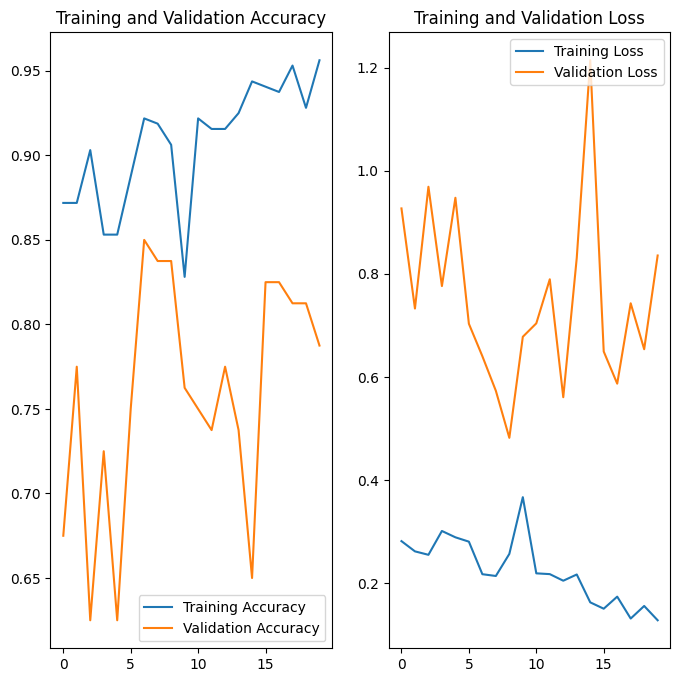

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
model.save('my_model.keras')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('my_model.keras')

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

# Load the test dataset
test_path = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/100TestingCNN',
    image_size=(180, 180),
    label_mode='binary',
    batch_size=32,
    shuffle='False')

# Create a mapping of class names to indices
class_indices = {class_name: i for i, class_name in enumerate(class_names)}

# Print the mapping
print(class_indices)

Found 100 files belonging to 2 classes.
{'Safe': 0, 'Unsafe': 1}


In [ ]:
# Get the class names
class_names = test_path.class_names
print("Class Names:", class_names)

# Make predictions on the test dataset (for each image)
predictions = model.predict(test_path)


Class Names: ['Safe', 'Unsafe']
4/4 [==============================] - 23s 70ms/step


In [ ]:
total_confidence = 0
total_predictions = len(predictions)
# Get the corresponding image name
image_names = '/content/drive/MyDrive/Dataset/100TestingCNN/Safe'

# Process predictions
for i, prediction in enumerate(predictions):
    # Normalize the prediction to get probabilities using softmax function
    probabilities = np.exp(prediction) / np.sum(np.exp(prediction))

    # Determine the predicted class index
    predicted_class_index = np.argmax(probabilities)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Get the confidence score (probability) for the predicted class
    confidence_score = probabilities[predicted_class_index]

    # Accumulate the confidence scores
    total_confidence += confidence_score

    # Print the predicted class name and confidence score for each image
    print(f"Image {i+1}: Name: {image_names}, Predicted Class: {predicted_class_name}, Confidence: {confidence_score}")

# Calculate the average confidence score
average_confidence = total_confidence / total_predictions
print("Average Confidence Score:", average_confidence)

Image 1: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.9997254014015198
Image 2: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.9994645118713379
Image 3: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.8825632929801941
Image 4: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.5447522401809692
Image 5: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.8814734816551208
Image 6: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.94575035572052
Image 7: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Safe, Confidence: 0.9993153810501099
Image 8: Name: /content/drive/MyDrive/Dataset/100TestingCNN/Safe, Predicted Class: Unsafe, Confidence: 0.9833318591117859
Image 9: Name: /content/drive/MyDrive/Da

In [ ]:
import os

# Directory containing the images
image_dir = '/content/drive/MyDrive/Dataset/100TestingCNN/Safe'

# Get the list of image names
image_names = os.listdir(image_dir)[:100]  # Assuming you want to process the first 100 images

# Process predictions for each image
for i, image_name in enumerate(image_names):
    # Assuming predictions is a list containing predictions for each image
    prediction = predictions[i]

    # Normalize the prediction to get probabilities using softmax function
    probabilities = np.exp(prediction) / np.sum(np.exp(prediction))

    # Determine the predicted class index
    predicted_class_index = np.argmax(probabilities)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Get the confidence score (probability) for the predicted class
    confidence_score = probabilities[predicted_class_index]

    # Accumulate the confidence scores
    total_confidence += confidence_score

    # Print the predicted class name and confidence score for each image
    print(f"Image {i+1}: Name: {image_name}, Predicted Class: {predicted_class_name}, Confidence: {confidence_score}")

# Calculate the average confidence score
average_confidence = total_confidence / len(image_names)
print("Average Confidence Score:", average_confidence)


Image 1: Name: CYJXNC23110301.jpg, Predicted Class: Safe, Confidence: 0.9997254014015198
Image 2: Name: PPT7715.jpg, Predicted Class: Safe, Confidence: 0.9994645118713379
Image 3: Name: F1119.jpg, Predicted Class: Safe, Confidence: 0.8825632929801941
Image 4: Name: E9335.jpg, Predicted Class: Safe, Confidence: 0.5447522401809692
Image 5: Name: L73130.jpg, Predicted Class: Safe, Confidence: 0.8814734816551208
Image 6: Name: NKOK 631.jpg, Predicted Class: Safe, Confidence: 0.94575035572052
Image 7: Name: E4629AS00.jpg, Predicted Class: Safe, Confidence: 0.9993153810501099
Image 8: Name: B077BS24FS.jpg, Predicted Class: Unsafe, Confidence: 0.9833318591117859
Image 9: Name: B0038AJYSS.jpg, Predicted Class: Safe, Confidence: 0.9112780094146729
Image 10: Name: PPT7717.jpg, Predicted Class: Safe, Confidence: 0.9750854969024658
Image 11: Name: HT909396.jpg, Predicted Class: Safe, Confidence: 0.8393968343734741
Image 12: Name: F30775L0.jpg, Predicted Class: Safe, Confidence: 0.9996504783630371


In [ ]:
import os

# Directory containing the images
image_dir = '/content/drive/MyDrive/Dataset/100TestingCNN/Unsafe'

# Get the list of image names
image_names = os.listdir(image_dir)[:100]  # Assuming you want to process the first 100 images

# Process predictions for each image
for i, image_name in enumerate(image_names):
    # Assuming predictions is a list containing predictions for each image
    prediction = predictions[i]

    # Normalize the prediction to get probabilities using softmax function
    probabilities = np.exp(prediction) / np.sum(np.exp(prediction))

    # Determine the predicted class index
    predicted_class_index = np.argmax(probabilities)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Get the confidence score (probability) for the predicted class
    confidence_score = probabilities[predicted_class_index]

    # Accumulate the confidence scores
    total_confidence += confidence_score

    # Print the predicted class name and confidence score for each image
    print(f"Image {i+1}: Name: {image_name}, Predicted Class: {predicted_class_name}, Confidence: {confidence_score}")

# Calculate the average confidence score
average_confidence = total_confidence / len(image_names)
print("Average Confidence Score:", average_confidence)


Image 1: Name: A120003324.jpg, Predicted Class: Safe, Confidence: 0.9997254014015198
Image 2: Name: A120315423.jpg, Predicted Class: Safe, Confidence: 0.9994645118713379
Image 3: Name: A120314623.jpg, Predicted Class: Safe, Confidence: 0.8825632929801941
Image 4: Name: A110013623.jpg, Predicted Class: Safe, Confidence: 0.5447522401809692
Image 5: Name: A110013523.jpg, Predicted Class: Safe, Confidence: 0.8814734816551208
Image 6: Name: A120308223.jpg, Predicted Class: Safe, Confidence: 0.94575035572052
Image 7: Name: A120100622.jpg, Predicted Class: Safe, Confidence: 0.9993153810501099
Image 8: Name: A120303623.jpg, Predicted Class: Unsafe, Confidence: 0.9833318591117859
Image 9: Name: A120301923.jpg, Predicted Class: Safe, Confidence: 0.9112780094146729
Image 10: Name: A120006024.jpg, Predicted Class: Safe, Confidence: 0.9750854969024658
Image 11: Name: A110002523.jpg, Predicted Class: Safe, Confidence: 0.8393968343734741
Image 12: Name: A120007524.jpg, Predicted Class: Safe, Confiden

In [ ]:
# Load the ground truth labels
test_labels = []
for images, labels in test_path:
    test_labels.extend(labels.numpy())

# Convert predictions to class labels
predicted_labels = []
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_labels.append(predicted_class_index)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.54


### Confusion Matrix


In [ ]:
#Evaluation with Confusion Matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Calculate performance metrics
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

        Safe       0.53      0.78      0.63        50
      Unsafe       0.58      0.30      0.39        50

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.55      0.54      0.51       100

Confusion Matrix:
[[39 11]
 [35 15]]


Text(0.5, 1.0, 'Image Classification of Unsafe Childrens Toys')

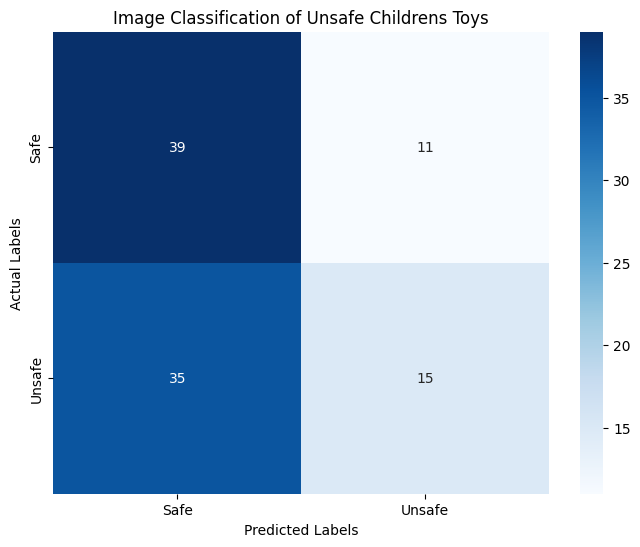

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Safe','Unsafe'], yticklabels=['Safe','Unsafe'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Image Classification of Unsafe Childrens Toys')


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
train_path = tf.keras.utils.image_dataset_from_directory (
  '/content/drive/MyDrive/Dataset/TrainingI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

train_path = tf.keras.utils.image_dataset_from_directory (
  '/content/drive/MyDrive/Dataset/TrainingI')
# Define parameters for loading the dataset
batch_size = 32

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
train_path = tf.keras.utils.image_dataset_from_directory (
  '/content/drive/MyDrive/Dataset/TrainingI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

# Load the training dataset
train_ds = train_path  # Assuming train_path is your dataset object

# Extract images and labels from the training dataset
train_images = []
train_labels = []
for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)

# Concatenate batches
train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

# Print the shape of the loaded data
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)

In [ ]:
# Assuming you have your data loaded as train_images, train_labels

# Define the number of folds for cross-validation
num_folds = 5

# Initialize KFold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define your image classification model using TensorFlow/Keras
model = tf.keras.Sequential([
    # Define your model architecture
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so output layer has 1 neuron with sigmoid activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # For binary classification
              metrics=['accuracy'])

# Initialize lists to store cross-validation accuracy
cv_accuracies = []

# Iterate over each fold
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
    print(f"Fold {fold + 1}/{num_folds}")

    import numpy as np

# Assuming train_indices and val_indices are already defined
# Convert train_indices and val_indices to NumPy arrays
train_indices_array = np.array(train_indices)
val_indices_array = np.array(val_indices)

# Verify index values and array dimensions
# Make sure that train_indices and val_indices contain valid index values

# Convert train_indices_array and val_indices_array to lists
train_indices_list = train_indices_array.tolist()
val_indices_list = val_indices_array.tolist()

In [ ]:
# Split data into training and validation sets for this fold
try:
    X_train, X_val = train_images[train_indices_list], train_images[val_indices_list]
    y_train, y_val = train_labels[train_indices_list], train_labels[val_indices_list]

    print("Shapes of train_images, X_train, X_val:", train_images.shape, X_train.shape, X_val.shape)
    print("Shapes of train_labels, y_train, y_val:", train_labels.shape, y_train.shape, y_val.shape)

    # Train the model on this fold
    # ...
except IndexError as e:
    print("IndexError occurred:", e)
    print("train_indices_list:", train_indices_list)
    print("val_indices_list:", val_indices_list)
except OverflowError as e:
    print("OverflowError occurred:", e)


In [ ]:
print("Max index in train_indices:", max(train_indices))
print("Max index in val_indices:", max(val_indices))
print("Train Indices List:", train_indices_list)
print("Validation Indices List:", val_indices_list)

In [ ]:
# Check for negative indices
if any(idx < 0 for idx in train_indices_list) or any(idx < 0 for idx in val_indices_list):
    print("Error: Negative indices are not allowed.")

# Check if indices exceed the length of the corresponding dimension
if max(train_indices_list) >= train_images.shape[0] or max(val_indices_list) >= train_images.shape[0]:
    print("Error: Indices exceed the length of the train_images array.")

# Check for duplicates in index lists
if len(train_indices_list) != len(set(train_indices_list)) or len(val_indices_list) != len(set(val_indices_list)):
    print("Error: Duplicate indices found in index lists.")


### Cross Validation Accuracy

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold

# Iterate over each fold
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
    print("Fold {}/{}".format(fold + 1, num_folds))

    # Convert indices to TensorFlow tensors
    train_indices_tensor = tf.constant(train_indices)
    val_indices_tensor = tf.constant(val_indices)

    # Split data into training and validation sets for this fold
    X_train, X_val = tf.gather(train_images, train_indices_tensor), tf.gather(train_images, val_indices_tensor)
    y_train, y_val = tf.gather(train_labels, train_indices_tensor), tf.gather(train_labels, val_indices_tensor)

    # Train the model on this fold
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), verbose=1)

In [ ]:
# Evaluate the model on the validation set for this fold
_, accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy for Fold {}: {}".format(fold + 1, accuracy))

# Append the accuracy to the list of cross-validation accuracies
cv_accuracies.append(accuracy)

# Print the list of cross-validation accuracies
print("Cross-Validation Accuracies:", cv_accuracies)

In [ ]:
# # Error analysis
# misclassified_images_indices = [i for i, (true_label, pred_label) in enumerate(zip(test_labels, predicted_labels)) if true_label != pred_label]
# print("Misclassified Images:")
# for i in misclassified_images_indices:
#     plt.imshow(images[i].astype("uint8"))
#     plt.title(f"Predicted Class: {class_names[predicted_labels[i]]}, True Class: {class_names[test_labels[i]]}")
#     plt.show()

# # Fine-tuning, deployment, and documentation steps are application-specific and may require additional implementation.

